# TM10007 Assignment

In [ ]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.9 MB/s eta 0:00:00


## Import packages

In [ ]:
import pandas as pd

from worcgist.load_data import load_data

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, VarianceThreshold
from sklearn.decomposition import PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## 1. Data loading

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [ ]:
# Load dataset with gastrointestinal stromal tumors and similar sarcomas
data = load_data()

# Assigning the labels to binary values
data['label'] = data['label'].map({'non-GIST': 0, 'GIST': 1})

# Splitting the labels from the feature values
y = data['label'] # Use these values for calculation of performance metric
X = data.drop(columns=['label'])

# Splitting the data: 85% for training/validation, 15% for final testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)                                                       # Stratify the split to ensure an equal class distribution across the splits

### 1.1: Basic statistics

Basic statistics:
       Set  Number of samples
0  X_train                209
1  y_train                209
2   X_test                 37
3   y_test                 37

The number of features: 493
The number of datapoints: 103037
The number of missing values: 0
The number of zero values: 5689
The percentage of zero values: 0.11743354329027438 %



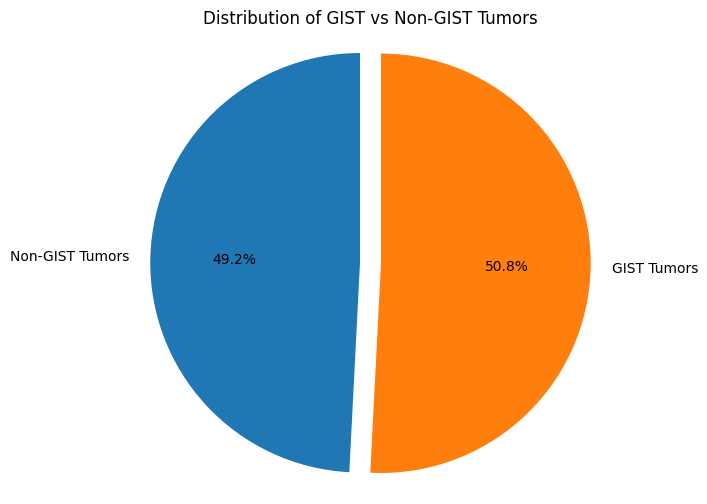

In [ ]:
# Calculate basic statistics of the dataset
data_sizes = {
    'Set': ['X_train', 'y_train', 'X_test', 'y_test'],
    'Number of samples': [len(X_train), len(y_train), len(X_test), len(y_test)]
    }

# Convert to DataFrame (makes it easier for printing results)
summary_df = pd.DataFrame(data_sizes)
n_samples = len(X_train)
n_features = len(X_train.columns)

n_missing = X_train.isna().sum().sum()
n_zero = (X_train == 0).sum().sum()

n_non_gist = (y == 0).sum().sum()
n_gist = (y == 1).sum().sum()

# Print basic statistics
print("Basic statistics:")
print(summary_df)

print(f'\nThe number of features: {n_features}')
print(f'The number of datapoints: {n_samples * n_features}')
print(f"The number of missing values: {n_missing}")
print(f"The number of zero values: {n_zero}")
print(f"The percentage of zero values: {n_non_gist/(n_samples*n_features)*100} %\n")

# Data for the pie chart
labels = ['Non-GIST Tumors', 'GIST Tumors']
sizes = [n_non_gist, n_gist]
explode = (0.05, 0.05)  # Slightly "explode" for emphasis in the plot

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode)
plt.title('Distribution of GIST vs Non-GIST Tumors')
plt.axis('equal')
plt.show()


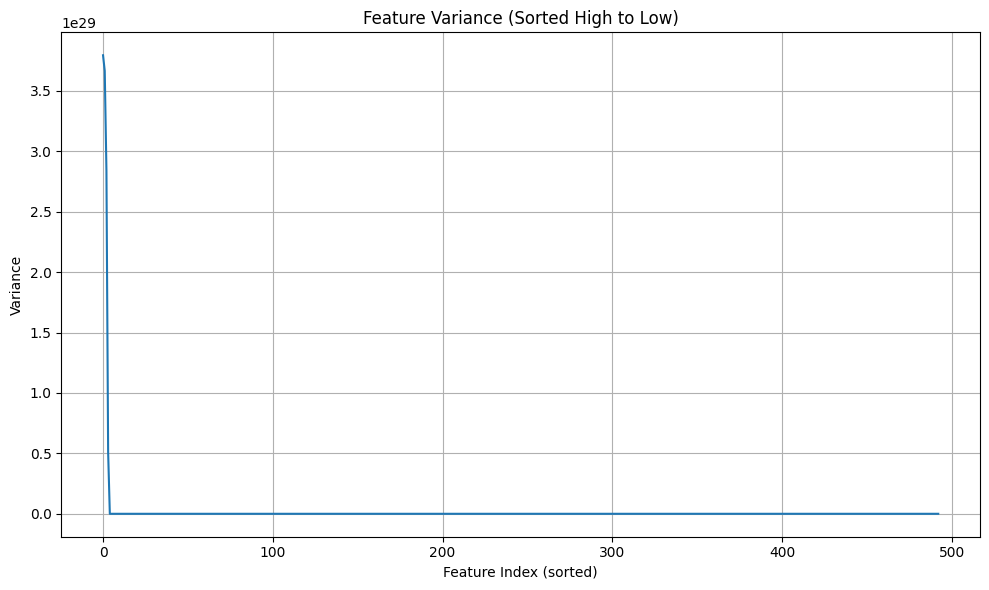

In [ ]:
# Calculate variance for the features
variances = X_train.var()  # Get variance of each feature/column
variances_sorted = variances.sort_values(ascending=False)

# Plot the variance for the differrent
plt.figure(figsize=(10, 6))
plt.plot(variances_sorted.values)
plt.ylabel('Variance')
plt.xlabel('Feature Index (sorted)')
plt.title('Feature Variance (Sorted High to Low)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 2. Pre-processing

The training data was preprocessed in 3 steps:


1.   Outliers replacecement
2.   Scaling
3.   Low variance features removed



### 2.1: Replace outliers

In [ ]:
# Shapiro-Wilk test on every column of x_final. Reject
alpha = 0.05  # Sets significance level
normal_results = {}  # Dictionary to store test results per feature

for col in X_train.columns:
    p_value = shapiro(X_train[col])[1]  # [1] gets p-value of tuple (statistic, p-value)
    normal_results[col] = p_value > alpha  # True = normal distribution

# Convert result to data frame (one row with feature column names and values true or false)
normality_df = pd.DataFrame([normal_results])

# Set thresholds for outlier detection
threshold_nd = 3   # z-score threshold for normally distributed data
threshold_nnd = 1.5  # IQR threshold for non-normally distributed data
outliers_list = []  # Empty list to store original outliers values

# To not overwrite x_clean, make copy of x_clean, data without constant columns and rows, and without "label" column.
X_no_outliers = X_train.astype(float).copy()  # Convert to float to prevent FutureWarnings

# From normality_df, get Series with column names as index and True/False as values
is_normal = normality_df.loc[0]

# Loop through all columns (features)
for column in X_no_outliers.columns:
    if is_normal[column]:
        # Normally distributed columns: z-score method
        # Determine interval boundaries
        mean = X_no_outliers[column].mean()
        std = X_no_outliers[column].std()
        lower_bound = mean - threshold_nd * std
        upper_bound = mean + threshold_nd * std  # All values outside this interval are considered outliers
        outliers = (X_no_outliers[column] < lower_bound) | (X_no_outliers[column] > upper_bound)  # Determine outliers
        outliers_list.extend(X_no_outliers.loc[outliers, column].tolist())  # Save outliers in outliers_list
        X_no_outliers.loc[X_no_outliers[column] > upper_bound, column] = upper_bound  # Replace outliers > upper boundary value with upper boundary value
        X_no_outliers.loc[X_no_outliers[column] < lower_bound, column] = lower_bound  # Replace outliers < lower boundary value with lower boundary value
    else:
        # Non-normally distributed columns: IQR-method
        # Determine interval boundaries
        Q1 = X_no_outliers[column].quantile(0.25)  # 25% of data values are less than or equal to Q1
        Q3 = X_no_outliers[column].quantile(0.75)  # 75% of data values are less than or equal to Q3
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold_nnd * IQR
        upper_bound = Q3 + threshold_nnd * IQR
        outliers = (X_no_outliers[column] > upper_bound) | (X_no_outliers[column] < lower_bound)  # Determine outliers
        outliers_list.extend(X_no_outliers.loc[outliers, column].tolist())  # Save outliers in outliers_list
        X_no_outliers.loc[X_no_outliers[column] > upper_bound, column] = upper_bound  # Replace outliers > upper boundary value with upper boundary value
        X_no_outliers.loc[X_no_outliers[column] < lower_bound, column] = lower_bound  # Replace outliers < lower boundary value with lower boundary value

# Result
print("Number of outliers replaced:", len(outliers_list))
print("Number of normally distributed features:", is_normal.sum())
print("Number of non-normally distributed features:", (~is_normal).sum())

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


Number of outliers replaced: 5269
Number of normally distributed features: 59
Number of non-normally distributed features: 434


### 2.2. Apply scaler

In [ ]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_no_outliers)
X_scaled_df = pd.DataFrame(X_scaled)

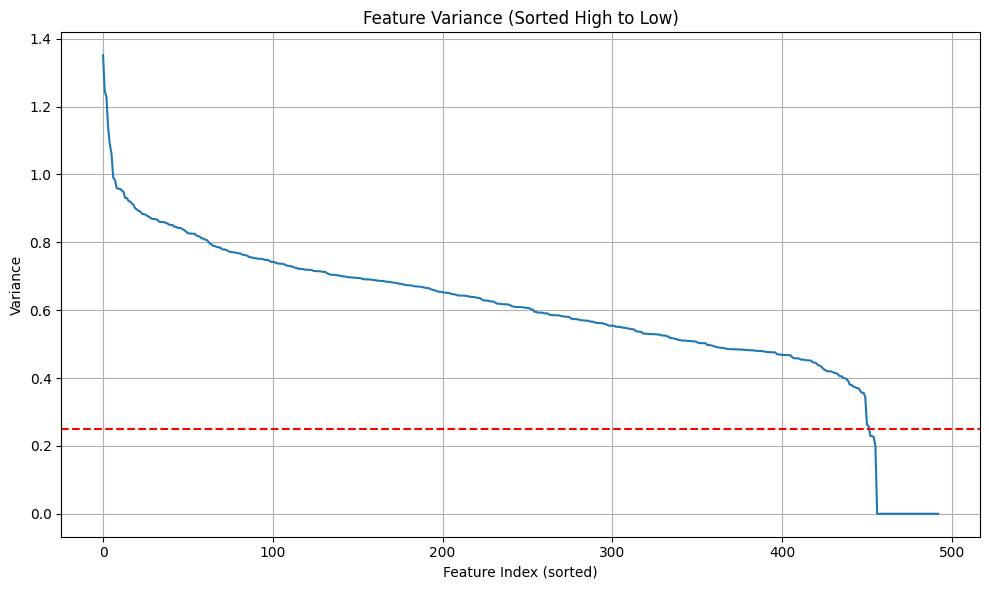

In [ ]:
variances = X_scaled_df.var()  # Get variance of each column
variances_sorted = variances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(variances_sorted.values)
plt.axhline(y=0.25, color='red', linestyle='--')
plt.ylabel('Variance')
plt.xlabel('Feature Index (sorted)')
plt.title('Feature Variance (Sorted High to Low)')
plt.grid(True)
plt.tight_layout()
plt.show()

### 2.3: Variance threshold

In [ ]:
# Step 2: Remove features with low variance
var_threshold = 0.25
selector = VarianceThreshold(threshold=var_threshold)

X_train_reduced = selector.fit_transform(X_scaled)
X_test_reduced = selector.transform(X_test)

selected_features = X.columns[selector.get_support()]

X_train_reduced_df = pd.DataFrame(X_train_reduced, columns=selected_features)
X_test_reduced_df = pd.DataFrame(X_test_reduced, columns=selected_features)

n_selected_features = X_train_reduced_df.shape[1]
n_removed_features = n_features - n_selected_features
print(f"Number of features removed: {n_removed_features}")

Number of features removed: 41


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but VarianceThreshold was fitted without feature names
  warnings.warn(


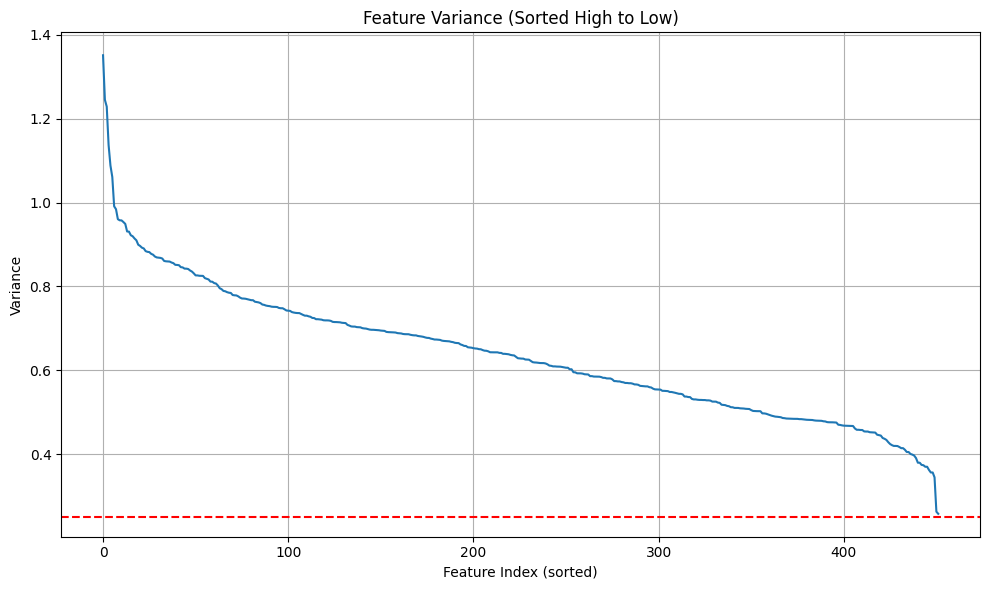

In [ ]:
variances = X_train_reduced_df.var()  # Get variance of each column
variances_sorted = variances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(variances_sorted.values)
plt.axhline(y=var_threshold, color='red', linestyle='--')
plt.ylabel('Variance')
plt.xlabel('Feature Index (sorted)')
plt.title('Feature Variance (Sorted High to Low)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 3. Model training pipeline

### 3.1. Model pipelines

In [ ]:
# Define pipelines for each classifier.

pipeline_svm = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('svm', SVC(class_weight='balanced', probability=True, random_state=42))])

pipeline_rf = Pipeline([
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))])

pipeline_xgb = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('XGB', XGBClassifier(random_state=42))])


In [ ]:
# Pipelines to be deleted?
# pipeline_dt = Pipeline([
#     ('pca', PCA(n_components=10)),
#     ('DT',DecisionTreeClassifier(random_state=42))
# ])
# pipeline_lr = Pipeline([
#     ('feature_selection', SelectFromModel(LogisticRegression(solver='liblinear', penalty='l1'))),
#     ('lr', LogisticRegression(max_iter=1000, random_state=42))
# ])
# pipeline_knn = Pipeline([
#     ('feature_selection', SelectKBest(score_func=f_classif, k=50)),
#     ('knn', KNeighborsClassifier())
# ])
# pipeline_mlp = Pipeline([
#     ('feature_selection', SelectKBest(score_func=f_classif, k=50)),
#     ('mlp', MLPClassifier(max_iter=1000, early_stopping=True, random_state=42))
# ])

### 3.2: Defining hyperparameter grids

In [ ]:
# Define hyperparameter grids for the models
svm_param_grid = [
    {
        'feature_selection__k': [50, 100, 150],
        'svm__kernel': ['linear'],
        'svm__C': [0.01, 0.1, 1, 10, 100],
        # 'svm__class_weight': ['balanced']
    },
    {
        'feature_selection__k': [50, 100, 150],
        'svm__kernel': ['rbf'],
        'svm__C': [0.01, 0.1, 1, 10, 100],
        'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1],
        # 'svm__class_weight': ['balanced']
    }]

rf_param_grid = [{
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    # 'rf__class_weight': ['balanced']
    }]

xgb_param_grid = [{
    'feature_selection__k': [50, 100, 150],
    'XGB__max_depth': [3, 5],
    'XGB__learning_rate': [0.05, 0.1],
    'XGB__n_estimators': [100],
}]

In [ ]:
# To be deleted?
# param_range = [1, 2, 3, 4, 5, 6]
# param_range_fl = [1.0, 0.5, 0.1]
# n_estimators = [50,100,150]
# learning_rates = [.1,.2,.3]

# svm_param_grid = [{'svm__kernel': ['linear', 'rbf'],
#                     'svm__C': param_range}]

# rf_param_grid = [{'rf__min_samples_leaf': param_range,
#                    'rf__max_depth': param_range,
#                    'rf__min_samples_split': param_range[1:]}]

# dt_param_grid = [{'DT__criterion': ['gini', 'entropy'],
#                    'DT__min_samples_leaf': param_range,
#                    'DT__max_depth': param_range,
#                    'DT__min_samples_split': param_range[1:]}]

# knn_param_grid = [{'knn__n_neighbors': param_range,
#                    'knn__weights': ['uniform', 'distance'],
#                    'knn__metric': ['euclidean', 'manhattan']}]

# lr_param_grid = [{'lr__penalty': ['l1', 'l2'],
#                    'lr__C': param_range_fl,
#                    'lr__solver': ['liblinear']}]

# mlp_param_grid = [{'mlp__hidden_layer_sizes': [(50,), (100,), (100, 50)],
#                    'mlp__activation': ['tanh', 'relu'],
#                    'mlp__solver': ['adam'],
#                    'mlp__alpha': [0.0001, 0.001],
#                    'mlp__learning_rate': ['constant','adaptive']}]

# xgb_param_grid = [{'XGB__learning_rate': learning_rates,
#                     'XGB__max_depth': param_range,
#                     'XGB__min_child_weight': param_range[:2],
#                     'XGB__subsample': param_range_fl,
#                     'XGB__n_estimators': n_estimators}]

### 3.3: Setup grid search

In [ ]:
# Setup grid search
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

svm_grid_search = GridSearchCV(estimator=pipeline_svm,
        param_grid=svm_param_grid,
        scoring='accuracy',
        cv=cv,
        n_jobs=-1)

rf_grid_search = GridSearchCV(estimator=pipeline_rf,
        param_grid=rf_param_grid,
        scoring='accuracy',
        cv=cv,
        n_jobs=-1)

xgb_grid_search = GridSearchCV(estimator=pipeline_xgb,
        param_grid=xgb_param_grid,
        scoring='accuracy',
        cv=cv,
        n_jobs=-1)

grids = [svm_grid_search, rf_grid_search, xgb_grid_search]

In [ ]:
# To be deleted?
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# svm_grid_search = GridSearchCV(estimator=pipeline_svm,
#         param_grid=svm_param_grid,
#         scoring='accuracy',
#         cv=cv)
# rf_grid_search = GridSearchCV(estimator=pipeline_rf,
#         param_grid=rf_param_grid,
#         scoring='accuracy',
#         cv=cv)
# dt_grid_search = GridSearchCV(estimator=pipeline_dt,
#         param_grid=dt_param_grid,
#         scoring='accuracy',
#         cv=cv)
# knn_grid_search = GridSearchCV(estimator=pipeline_knn,
#         param_grid=knn_param_grid,
#         scoring='accuracy',
#         cv=cv)
# lr_grid_search = GridSearchCV(estimator=pipeline_lr,
#         param_grid=lr_param_grid,
#         scoring='accuracy',
#         cv=cv)
# mlp_grid_search = GridSearchCV(estimator=pipeline_mlp,
#         param_grid=mlp_param_grid,
#         scoring='accuracy',
#         cv=cv)
# xgb_grid_search = GridSearchCV(estimator=pipeline_xgb,
#         param_grid=xgb_param_grid,
#         scoring='accuracy',
#         cv=cv)
# grids = [svm_grid_search, rf_grid_search, dt_grid_search, knn_grid_search, lr_grid_search, mlp_grid_search, xgb_grid_search]

### 3.4: Execute training

In [ ]:
for pipe in grids:
    pipe.fit(X_no_outliers,y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 76  77  83  84  85  89  90  92  96  97  98 102 103 105 109 110 111 113
 322 415 422 423 428 435 436 441 448 449 467 470 474 475 480 483 487 488
 491] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 76  77  83  84  85  89  90  92  96  97  98 102 103 105 109 110 111 113
 322 415 422 423 428 435 436 441 448 449 467 470 474 475 480 483 487 488
 491] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeW

## 4. Model evaluation

In [ ]:
# # grid_dict = {0: 'Support Vector Machine', 1: 'Random Forrest', 2: 'Decision Tree',
# #              3: 'K Nearest Neighbor', 4: 'Logistic Regression', 5: 'multi-layer perceptron',
# #              6: 'XGBoost'}

# grid_dict = {0: 'Support Vector Machine', 1: 'Random Forrest', 2: 'XGBoost'}
# results_list = []

# for i, model in enumerate(grids):
#     model_name = grid_dict[i]
#     accuracy = model.score(X_test_reduced_df, y_test)
#     best_params = model.best_params_

#     results_list.append({
#         'Model': model_name,
#         'Test Accuracy': accuracy,
#         'Best Hyperparameters': best_params
#     })

# results_df = pd.DataFrame(results_list)
# results_df.sort_values(by='Test Accuracy', ascending=False, inplace=True)

# from IPython.display import display

# pd.set_option('display.max_colwidth', 200)
# display(results_df)


=== Support Vector Machine ===
Accuracy: 0.7568
Precision: 0.7273
Recall: 0.8421
F1-score: 0.7805
ROC AUC: 0.7164
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        18
           1       0.73      0.84      0.78        19

    accuracy                           0.76        37
   macro avg       0.76      0.75      0.75        37
weighted avg       0.76      0.76      0.75        37


Best Hyperparameters: {'feature_selection__k': 50, 'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}



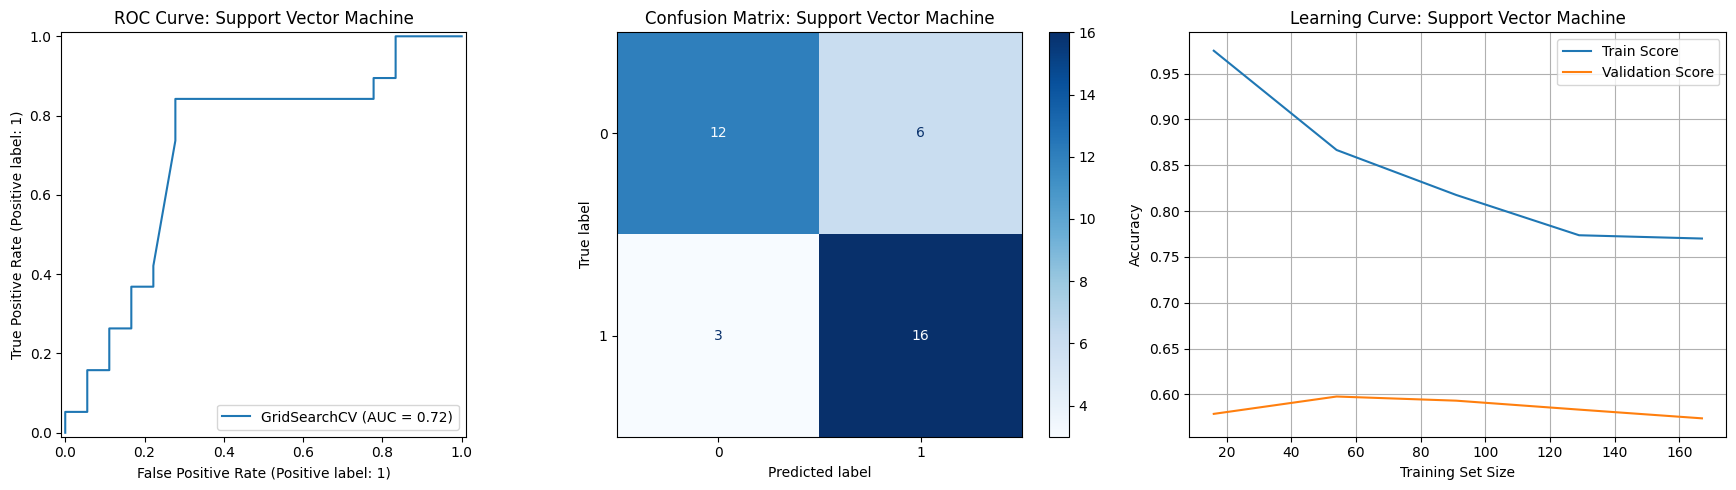


=== Random Forrest ===
Accuracy: 0.7297
Precision: 0.6957
Recall: 0.8421
F1-score: 0.7619
ROC AUC: 0.7368
              precision    recall  f1-score   support

           0       0.79      0.61      0.69        18
           1       0.70      0.84      0.76        19

    accuracy                           0.73        37
   macro avg       0.74      0.73      0.72        37
weighted avg       0.74      0.73      0.73        37


Best Hyperparameters: {'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}



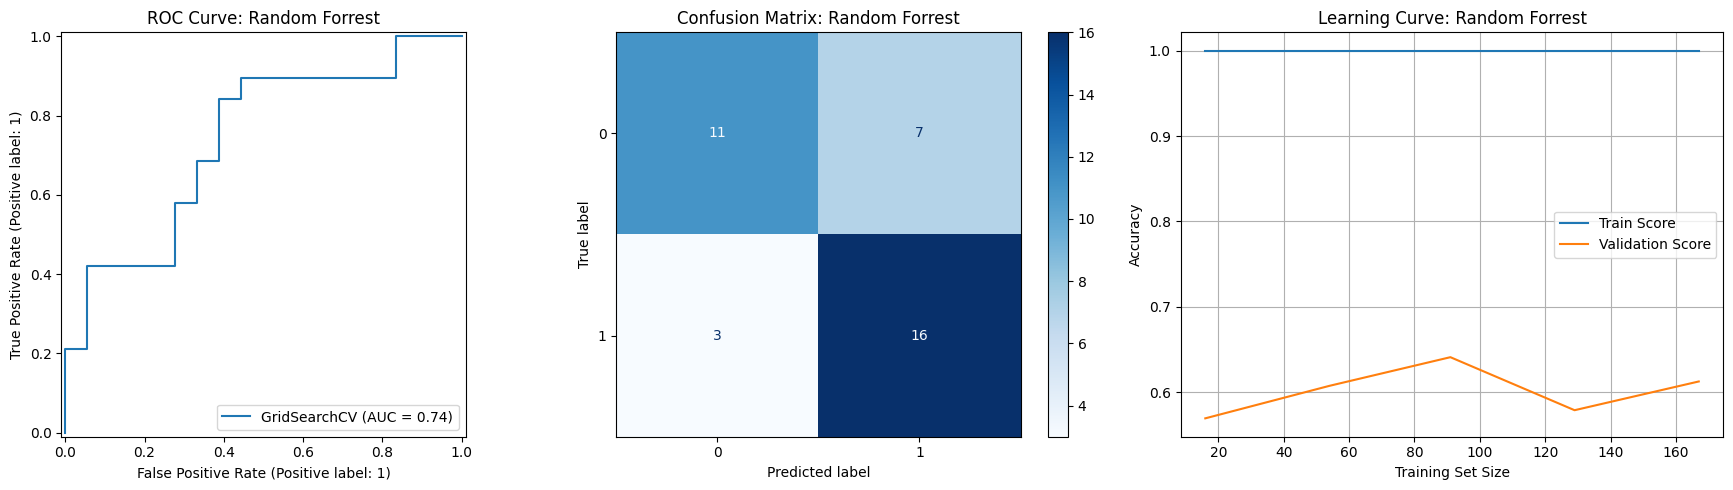


=== XGBoost ===
Accuracy: 0.6216
Precision: 0.6923
Recall: 0.4737
F1-score: 0.5625
ROC AUC: 0.6813
              precision    recall  f1-score   support

           0       0.58      0.78      0.67        18
           1       0.69      0.47      0.56        19

    accuracy                           0.62        37
   macro avg       0.64      0.63      0.61        37
weighted avg       0.64      0.62      0.61        37


Best Hyperparameters: {'XGB__learning_rate': 0.05, 'XGB__max_depth': 3, 'XGB__n_estimators': 100, 'feature_selection__k': 50}



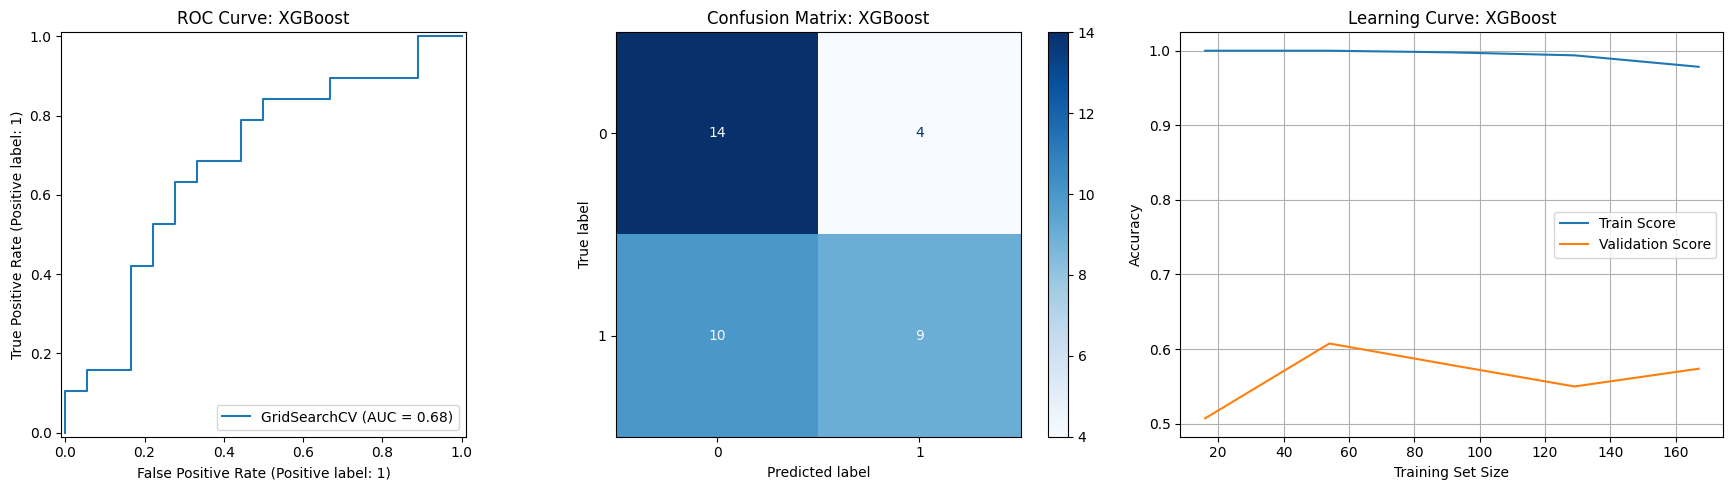

In [ ]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.metrics import (
    classification_report, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, precision_score, recall_score, f1_score
)

# First define the names of the 3 classifiers used for the different models
grid_dict = {0: 'Support Vector Machine', 1: 'Random Forrest', 2: 'XGBoost'}

#
for i, model in enumerate(grids):
    model_name = grid_dict[i]
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    accuracy = model.score(X_test, y_test)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba)
    best_params = model.best_params_

    print(f"\n=== {model_name} ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f"\nBest Hyperparameters: {best_params}\n")

    # Figuur met ROC + Confusion Matrix
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=axes[0])
    axes[0].set_title(f'ROC Curve: {model_name}')

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=model.classes_, cmap='Blues', ax=axes[1])
    axes[1].set_title(f'Confusion Matrix: {model_name}')

    # Learning curve
    train_sizes, train_scores, val_scores = learning_curve(
        model.best_estimator_, X_no_outliers, y_train,
        cv=5, scoring='accuracy', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=42
    )
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    axes[2].plot(train_sizes, train_mean, label='Train Score')
    axes[2].plot(train_sizes, val_mean, label='Validation Score')
    axes[2].set_title(f'Learning Curve: {model_name}')
    axes[2].set_xlabel('Training Set Size')
    axes[2].set_ylabel('Accuracy')
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()
